# Implementation

[Relationship between PCA and SVD](https://stats.stackexchange.com/a/134283)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
class gram_schmidt:
    '''def __init__(self, X):
        self.X = X.astype(float)'''
        
    def _proj(self, u, v):
        return (np.vdot(v, u) / np.vdot(u,u))*u
    
    def fit_transform(self, X, col_vec = True, normal = True):
        #X = X.astype(float)
        if col_vec:
            mat = X.copy()
        else:
            mat = (X.T).copy()
        
        N = mat.shape[1]
        mat_orth = np.array([]).reshape(mat.shape[0], -1)
        for n in range(N):
            u = mat[:, n:n+1].copy()
            if n ==0:
                mat_orth = np.hstack((mat_orth,u))
            else:
                for i in range(n):
                    u -= self._proj(mat_orth[:, i:i+1], mat[:, n:n+1])
                mat_orth = np.hstack((mat_orth,u))
        
        if normal:
            result = mat_orth / np.linalg.norm(mat_orth, axis=0)
            if col_vec:
                return result
            else:
                return result.T
        else:
            if col_vec:
                return mat_orth
            else:
                return mat_orth.T

In [4]:
def svd_thin(data, ):
    dim = data.shape[1]
    rank = np.linalg.matrix_rank(data)
    relu = np.vectorize(lambda x: np.real(x) if np.real(x)>=0 else .0)
    
    #eval_u, evec_u = np.linalg.eig(data.dot(data.T), )
    eval_v, evec_v = np.linalg.eig(data.T.dot(data), )
    
    gs = gram_schmidt()
    #evec_u_gs = gs.fit_transform(evec_u)
    evec_v_gs = gs.fit_transform(evec_v)
        
    s = eval_v.copy()
    s = np.sqrt(relu(s))
    s1 = np.sort(s)[::-1]
    if dim > rank:
        s1[-(dim-rank):] = 0
    
    S = np.eye(dim)*s1
    
    v_idx = np.sqrt(relu(np.real(eval_v))).argsort()[-dim:][::-1]
    v = evec_v_gs[:, v_idx ]
    
    u = data.dot(v)/s1
    
    return u, S,  v

# Codes

In [11]:
data = make_classification(n_redundant=0, 
                           n_samples=10**6, weights=[0.9], random_state= 42, )

$\large \mathbf{X} = {\begin{pmatrix} x_{1,1}&\cdots&x_{1,p} \\ \vdots & \ddots &\vdots \\ x_{n,1}&\cdots&x_{n,p} \end{pmatrix} }_{n\times p} = {\begin{pmatrix} X_1 & \cdots&X_p \end{pmatrix} }_{n\times p}$ where $n$ is the number of samples and $p$ is the number of features.

In [18]:
data_x = data[0]
data_y = data[1]

print('shape of X:', data_x.shape)

shape of X: (1000000, 20)


$\large \mathbf{X}_{\normalsize standardized} = \begin{pmatrix} \frac{X_1 -  \mu_1}{\sigma_1} & \frac{X_2 -  \mu_2}{\sigma_2} & \cdots &\frac{X_p -  \mu_p}{\sigma_p}  \end{pmatrix} $, where $\mu_i$ and $\sigma_i$ are mean and standard deviation of a vector $X_i$ for $i \in \{1,2,\cdots,p\}$.

Therefore, the means of each column of matrix $\mathbf{X}_{\normalsize standardized}$ are all 0 and standard deviations are all 1.

In [13]:
scaler = StandardScaler()
data_x_std = scaler.fit_transform(data_x)

print('means of each columns are all 0?:', np.allclose(data_x_std.mean(axis=0), np.zeros(data_x_std.shape)))
print('standard deviations of each columns are all 1?:', np.allclose(data_x_std.std(axis=0), np.ones(data_x_std.shape)))

means of each columns are all 0?: True
standard deviations of each columns are all 1?: True


Reduce the dimension of the maxrix $X$ from $p$ to $2$.

In [14]:
dim_reduced = 2

## Using scikit-learn

In [16]:
start = time.time()

pca = PCA(n_components= dim_reduced, svd_solver='full')
xpca = pca.fit_transform(data_x_std)

end = time.time()
print('runtime:', end - start)

runtime: 0.8139309883117676


The amount of variance explained by each of the selected components.

The 0th component of explained_variance_ equals to variance of 0th column of the matrix $X_{pca}$ with $ddof = 1$.

In [17]:
pca.explained_variance_

array([1.07743561, 1.00654863])

In [25]:
print('pca.explained_variance_[0] == xpca[:, 0].var(ddof=1)?:', np.allclose(pca.explained_variance_[0], xpca[:, 0].var(ddof=1)))

pca.explained_variance_[0] == xpca[:, 0].var(ddof=1)?: True


$\large  Comp = \begin{bmatrix} V_{comp1} & V_{comp2} \end{bmatrix}$ 

In [234]:
pca.components_.T

array([[-0.70599712, -0.02179824],
       [-0.03820457, -0.29716737],
       [-0.00511981,  0.24191311],
       [ 0.00316976, -0.1552799 ],
       [-0.00607306,  0.19315766],
       [ 0.01378161, -0.31379142],
       [ 0.01395261, -0.19963659],
       [-0.01303674, -0.10695125],
       [ 0.00663818,  0.12910551],
       [-0.01650511, -0.02872533],
       [ 0.00849686,  0.44358762],
       [-0.01663547, -0.19563718],
       [-0.00496126,  0.17365063],
       [-0.01661978,  0.05243992],
       [ 0.02078452, -0.28187502],
       [-0.01667663,  0.14918825],
       [-0.00635741,  0.06491868],
       [ 0.7051932 , -0.00858833],
       [-0.00136236, -0.16749529],
       [-0.02155668,  0.47118897]])

$\large \lVert V_{comp1} \rVert = \lVert V_{comp2} \rVert = 1$ 

$\large V_{comp1} \perp V_{comp2}$

In [235]:
(pca.components_).dot(pca.components_.T)

array([[1.00000000e+00, 9.03251854e-17],
       [9.03251854e-17, 1.00000000e+00]])

$\large X_{pca} = X_{standardized} \times Comp = X_{standardized} \times \begin{bmatrix} V_{comp1} & V_{comp2} \end{bmatrix}$

In [27]:
print('xpca == data_x_std.dot(pca.components_.T)?:', np.allclose(xpca, data_x_std.dot(pca.components_.T)))

xpca == data_x_std.dot(pca.components_.T)?: True


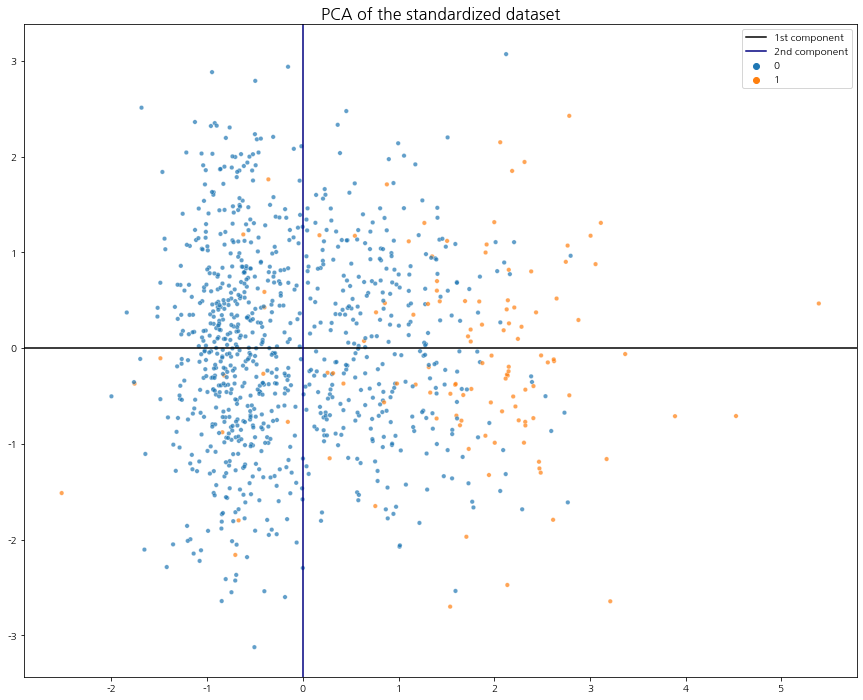

In [100]:
fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)
ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')

show_n_samp = 1000
sns.scatterplot(x = xpca[:show_n_samp, 0], y=xpca[:show_n_samp, 1], hue=data_y[:show_n_samp],  alpha=.7 , s=20)
plt.title('PCA of the standardized dataset', fontsize = 16)
plt.show()

## Using numpy

### with EVD of covariance matrix

$\large \mathrm{Cov}(X) = {\begin{pmatrix} \mathrm{cov}[X_1, X_1] & \cdots & \mathrm{cov}[X_1, X_p] \\ \vdots & \ddots &\vdots \\ \mathrm{cov}[X_p, X_1] & \cdots & \mathrm{cov}[X_p, X_p]\end{pmatrix}}_{p\times p} = {\begin{pmatrix} \mathrm{var}[X_1] & \cdots & \mathrm{cov}[X_1, X_p] \\ \vdots & \ddots &\vdots \\ \mathrm{cov}[X_p, X_1] & \cdots & \mathrm{var}[X_p]\end{pmatrix}}_{p\times p}$

In [53]:
cov = np.cov(data_x_std, rowvar=False)

If a matrix is already standardized, $\large \mathrm{Cov}(X) = \frac{1}{n-1} X^T X$ where n is the number of samples i.e. rows.

In [54]:
np.allclose(cov, (data_x_std.T).dot(data_x_std)/(data_x_std.shape[0]-1))

True

$\large V$ is a set of eigenvectors of $\mathrm{Cov}(X)$.

$\large \Lambda$ is a diagonal square matrix whose diagonal entries are eigenvalues of $\mathrm{Cov}(X)$.

In [57]:
evalues, evectors = np.linalg.eig(cov)
evalues_mat = np.sort(evalues)[::-1] * np.eye(evalues.size)

* Sort the columns of $\large V$ in descending order of those eigenvalues.

In [58]:
evectors = evectors[:,evalues.argsort()[::-1]]

$\large \mathrm{Cov}(X) = V \Lambda V^{-1} = V \Lambda V^T$

In [60]:
np.allclose(cov, evectors.dot(evalues_mat.dot(evectors.T)))

True

$\large X_{pca} = X_{standardized} \times \begin{bmatrix} V_{1} & V_{2} \end{bmatrix}$ where v1, v2 are the first two columns of eigenvectors $V$.

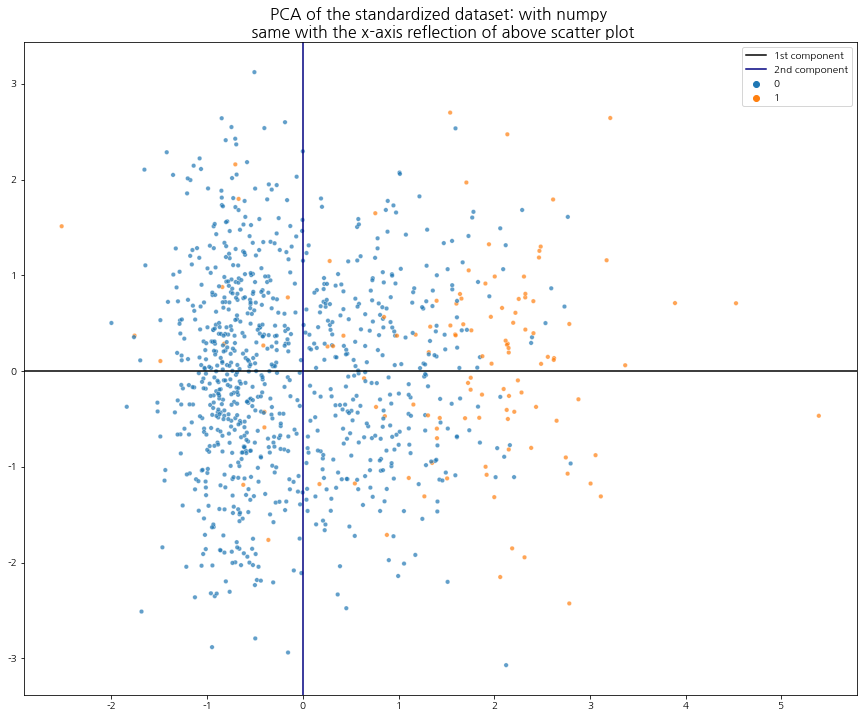

In [104]:
data_x_pca = data_x_std.dot(evectors[:,:dim_reduced])
comp_reduced = (evectors[:,:dim_reduced].T).dot(evectors[:,:dim_reduced])

fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)

ax.axline((.0, .0), (comp_reduced[0,0], comp_reduced[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (comp_reduced[1,0], comp_reduced[1,1]), c='navy', label='2nd component')

show_n_samp = 1000
sns.scatterplot(x = data_x_pca[:show_n_samp, 0], y=data_x_pca[:show_n_samp, 1], hue=data_y[:show_n_samp],  alpha=.7 , s=20)
plt.title('PCA of the standardized dataset: with numpy \n same with the x-axis reflection of above scatter plot', fontsize = 16)
plt.show()

### with SVD of dataset

In [245]:
# with numpy SVD

start = time.time()

u, s, vh = np.linalg.svd(data_x_std, full_matrices=False)

xpca1 = data_x_std.dot(vh.T)[:,:dim_reduced]
end = time.time()
print(end - start)

0.7391486167907715


In [105]:
# with the implemented SVD by me

start = time.time()

u, s, v = svd_thin(data_x_std, )

xpca1 = data_x_std.dot(v[:,evalues.argsort()[-dim_reduced:][::-1]])#[:,:dim_reduced]
end = time.time()
print(end - start)

0.28076887130737305


In [247]:
(v[:,evalues.argsort()[-dim_reduced:][::-1]].T).dot(v[:,evalues.argsort()[-dim_reduced:][::-1]])

array([[1.00000000e+00, 8.67361738e-19],
       [8.67361738e-19, 1.00000000e+00]])

In [250]:
np.linalg.det(v)

-1.0

In [251]:
np.sign(vh[0,:]) * np.sign(v.T[0,:])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [85]:
v.T[0,:]

array([-2.98939812e-04, -1.32838027e-03,  3.14108774e-03,  3.94970840e-03,
       -7.07087900e-01,  8.13257028e-04,  1.03690962e-03,  1.75343268e-03,
        7.07086188e-01, -5.33569601e-04,  1.88006108e-03, -3.11124159e-04,
        2.30049766e-03,  2.09740546e-03,  1.16345787e-03, -1.35068057e-03,
        8.98664207e-04,  3.39102434e-04, -2.38040393e-03, -5.64287385e-04])

In [81]:
np.linalg.det(v)

0.9999999999999998

In [91]:
pca.explained_variance_

array([1.2028485 , 1.00241265])

In [92]:
np.square(s.diagonal())/(data_x_std.shape[0])

array([1.20284838, 1.00241255, 1.0019211 , 1.00173896, 1.0014749 ,
       1.001388  , 1.00113556, 1.00050365, 1.00038223, 1.00014336,
       0.99978268, 0.99966652, 0.99955562, 0.99893446, 0.99885065,
       0.99855887, 0.99810098, 0.99791234, 0.99753153, 0.79715766])

In [89]:
xpca1

array([[ 0.48750003, -0.42484167],
       [ 0.24889897,  0.29967332],
       [ 1.27482779, -0.45661156],
       ...,
       [-1.03769128,  0.27089073],
       [-1.35251313,  0.11645284],
       [ 1.48213888,  0.79614934]])

In [90]:
xpca

array([[-0.48750003, -0.42484167],
       [-0.24889897,  0.29967332],
       [-1.27482779, -0.45661156],
       ...,
       [ 1.03769128,  0.27089073],
       [ 1.35251313,  0.11645284],
       [-1.48213888,  0.79614934]])

In [59]:
data_x_std.dot(vh.T)[:,:dim_reduced]

array([[-0.48750003, -0.42484167],
       [-0.24889897,  0.29967332],
       [-1.27482779, -0.45661156],
       ...,
       [ 1.03769128,  0.27089073],
       [ 1.35251313,  0.11645284],
       [-1.48213888,  0.79614934]])

$$
\large X = U S V^*
$$

In [127]:
u, s, v = np.linalg.svd(X_train_sc, full_matrices=True, )

In [ ]:
np.diag

In [145]:
eval_u, evec_u = np.linalg.eig(X_train_sc.dot(X_train_sc.T))
eval_v, evec_v = np.linalg.eig(X_train_sc.T.dot(X_train_sc))

In [143]:
s

array([4.97506427e+01, 3.13717390e+01, 3.09977810e+01, 3.09153138e+01,
       2.99903288e+01, 2.95646369e+01, 2.94278799e+01, 2.91018804e+01,
       2.89310347e+01, 2.83078598e+01, 2.78897188e+01, 2.73841088e+01,
       2.70829421e+01, 2.64796516e+01, 2.57036546e+01, 2.54668170e+01,
       2.49809806e+01, 2.45693326e+01, 1.71043071e-14, 6.79398003e-15])

In [144]:
np.sqrt(1.43439627e-13)

3.7873424323659985e-07

In [149]:
set(np.real(eval_u)).intersection(set(np.real(eval_v)))

set()

In [161]:
np.sqrt(abs(np.real(eval_v))).argsort()

array([19, 18,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 16, 15, 14,  9,  3,
        2,  1,  0], dtype=int64)

In [170]:
v.T[0,:]

array([-2.29222837e-02,  5.05722912e-01, -6.56554623e-02,  1.11001843e-01,
       -2.38002695e-01,  8.32706762e-02,  1.72357613e-01,  8.64398786e-02,
       -1.29605480e-02,  4.39800060e-01, -3.06539027e-01,  3.62347473e-02,
       -2.50551049e-03, -1.59530740e-02, -2.07104101e-01,  2.14519904e-01,
        4.72252971e-01, -1.58942830e-01,  5.97211875e-17, -3.02034327e-17])

In [172]:
np.real(evec_v[:,np.sqrt(abs(np.real(eval_v))).argsort()[::-1]])[0,:]

array([-2.29222837e-02, -5.05722912e-01,  6.56554623e-02,  1.11001843e-01,
       -2.38002695e-01, -8.32706762e-02, -1.72357613e-01, -8.64398786e-02,
        1.29605480e-02,  4.39800060e-01,  3.06539027e-01,  3.62347473e-02,
       -2.50551049e-03,  1.59530740e-02, -2.07104101e-01,  2.14519904e-01,
        4.72252971e-01,  1.58942830e-01, -3.21000690e-17, -3.21000690e-17])

In [129]:
gs = gram_schmidt()
ev_orth = np.real(gs.orthonormal(ev, ))

In [132]:
v.T[0,:]

array([-2.29222837e-02,  5.05722912e-01, -6.56554623e-02,  1.11001843e-01,
       -2.38002695e-01,  8.32706762e-02,  1.72357613e-01,  8.64398786e-02,
       -1.29605480e-02,  4.39800060e-01, -3.06539027e-01,  3.62347473e-02,
       -2.50551049e-03, -1.59530740e-02, -2.07104101e-01,  2.14519904e-01,
        4.72252971e-01, -1.58942830e-01,  5.97211875e-17, -3.02034327e-17])

In [133]:
ev_orth[0,:]

array([-2.29222837e-02, -5.05722912e-01,  6.56554623e-02,  1.11001843e-01,
        1.58942830e-01,  4.72252971e-01,  2.14519904e-01, -2.07104101e-01,
        1.59530740e-02, -2.38002695e-01, -2.50551049e-03,  3.62347473e-02,
        3.06539027e-01,  4.39800060e-01, -8.32706762e-02, -1.72357613e-01,
       -8.64398786e-02,  1.29605480e-02,  1.56755213e-17, -8.81978737e-18])

In [124]:
np.linalg.norm(ev_orth[:,1])

1.0000000000000002

In [123]:
np.linalg.norm(v.T[:,1])

1.0000000000000002

In [96]:
np.isclose(v[:,:3],np.real(gs.orthonormal(ev, )[:,:3]))

array([[ True, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [97]:
v.T[:,:3] 

array([[-0.02292228,  0.50572291, -0.06565546],
       [ 0.55962697,  0.05425466, -0.04748907],
       [-0.0203438 , -0.01816242, -0.51729607],
       [ 0.00109865, -0.1577597 , -0.07062832],
       [-0.04118024, -0.25275819, -0.01802699],
       [-0.47676204,  0.15049368, -0.05232398],
       [ 0.0125351 ,  0.09318769,  0.45878404],
       [ 0.01736969, -0.20223319, -0.02511544],
       [ 0.03330077,  0.05702416, -0.17681541],
       [-0.00782674, -0.28581579,  0.09669366],
       [-0.01586192,  0.22138756, -0.18911348],
       [ 0.01047088, -0.24002708, -0.27383818],
       [ 0.02324671,  0.06861466, -0.03325629],
       [ 0.05600357,  0.1658956 ,  0.48019901],
       [-0.37526174, -0.21968459,  0.11830003],
       [ 0.00791182, -0.35257137, -0.07828296],
       [-0.02624688,  0.30492018,  0.00310865],
       [-0.01452093,  0.1160483 , -0.10764729],
       [ 0.55590289, -0.05176735,  0.00266235],
       [-0.02001138,  0.27290482, -0.30312492]])

In [100]:
ev_orth

array([[-0.02292228, -0.50572291,  0.06565546],
       [ 0.55962697, -0.05425466,  0.04748907],
       [-0.0203438 ,  0.01816242,  0.51729607],
       [ 0.00109865,  0.1577597 ,  0.07062832],
       [-0.04118024,  0.25275819,  0.01802699],
       [-0.47676204, -0.15049368,  0.05232398],
       [ 0.0125351 , -0.09318769, -0.45878404],
       [ 0.01736969,  0.20223319,  0.02511544],
       [ 0.03330077, -0.05702416,  0.17681541],
       [-0.00782674,  0.28581579, -0.09669366],
       [-0.01586192, -0.22138756,  0.18911348],
       [ 0.01047088,  0.24002708,  0.27383818],
       [ 0.02324671, -0.06861466,  0.03325629],
       [ 0.05600357, -0.1658956 , -0.48019901],
       [-0.37526174,  0.21968459, -0.11830003],
       [ 0.00791182,  0.35257137,  0.07828296],
       [-0.02624688, -0.30492018, -0.00310865],
       [-0.01452093, -0.1160483 ,  0.10764729],
       [ 0.55590289,  0.05176735, -0.00266235],
       [-0.02001138, -0.27290482,  0.30312492]])

In [99]:
gs = gram_schmidt()
ev_orth = np.real(gs.orthonormal(ev, )[:,:3])

In [60]:
u

array([[-3.58069699e-02,  3.01698041e-02, -3.92649977e-03, ...,
         2.50448298e-02, -3.82197662e-02, -3.66543863e-02],
       [-5.22878445e-03, -3.06603742e-02,  1.55813512e-02, ...,
        -2.54367666e-02, -4.40285614e-02, -1.38019509e-02],
       [ 4.67882864e-03, -7.81796912e-02, -1.31807645e-02, ...,
        -3.06775784e-02,  3.01705551e-02, -1.05746981e-02],
       ...,
       [-2.34054071e-02, -6.97085261e-02,  8.71660084e-03, ...,
         9.75102822e-01,  7.05642576e-04,  2.80920160e-03],
       [-1.42460634e-02, -7.98736725e-03, -2.16604159e-02, ...,
         1.85549046e-03,  9.82551168e-01,  6.20014067e-03],
       [-1.94011010e-02,  2.70296071e-02,  4.82344894e-03, ...,
         6.53096767e-04,  5.39052629e-03,  9.84550389e-01]])

In [18]:
cov= np.cov(X_train_sc - X_train_sc.mean(axis=0), rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [109]:
u.dot(np.diag(s))

(800, 20)

In [104]:
xpca

array([[ 1.77774354, -0.58563607],
       [ 0.2612659 ,  0.59186165],
       [-0.23103433,  2.09704588],
       ...,
       [ 1.16470754,  2.06088412],
       [ 0.70823629,  0.47223255],
       [ 0.96628558, -1.09295898]])

In [101]:
(X_train_sc - X_train_sc.mean(axis=0)).dot(pca.components_.T)

array([[ 1.78141977, -0.94647922],
       [ 0.26013539,  0.96186926],
       [-0.23277473,  2.45263287],
       ...,
       [ 1.16443405,  2.18687769],
       [ 0.70875081,  0.2505776 ],
       [ 0.96521724, -0.84796578]])

In [79]:
np.allclose(xpca, X_train_sc.dot(pca.components_.T))

False

In [75]:
X_train_sc.var()

0.9999999999999993

In [71]:
pca.explained_variance_

array([3.0668676 , 0.93813866])

In [74]:
(X_train_sc - X_train_sc.mean(axis=0)).dot(pca.components_.T).var(axis=0, ddof=1)

array([3.0668676 , 0.93813866])

In [19]:
np.allclose(v[0], eigenvectors.T[0])

False

In [20]:
eigenvectors[0,1]

-0.5057229118627715

In [21]:
np.isclose(abs(v), abs(eigenvectors.T))

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [False, False, False, False],
       [False, False, False, False]])

In [20]:
np.allclose(v.T.dot(v), np.eye(v.shape[0]))

True

In [22]:
np.isclose(eigenvectors.T.dot(eigenvectors), np.eye(eigenvectors.shape[0]))

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True, False],
       [ True,  True, False,  True]])

In [26]:
X_train_sc.shape

(800, 4)

In [69]:
comp_idx = 0
cosine_similarity(v[comp_idx:comp_idx+1,:], eigenvectors[:,comp_idx].reshape(1,-1))

array([[-1.]])

In [85]:
((u.T).dot(u) - np.eye(800)).min()

-1.7763568394002505e-15

In [27]:
np.allclose((u.T).dot(u) , np.eye(u.shape[0]))

True

In [28]:
np.allclose((v.T).dot(v) , np.eye(v.shape[0]))

True

In [82]:
np.round((u.T).dot(u) - np.eye(800), 2)

array([[ 0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ..., -0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0., -0., -0.]])

In [77]:
np.round((v.T).dot(v), 2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -0.,  0.,  1.]])

In [75]:
eigenvectors.dot( np.matrix(eigenvectors).H)

matrix([[ 1.01230942,  0.06288618, -0.03379583, -0.08403019],
        [ 0.06288618,  1.14011871,  0.01014754, -0.09029393],
        [-0.03379583,  0.01014754,  0.90831919, -0.11137876],
        [-0.08403019, -0.09029393, -0.11137876,  0.93925268]])

In [78]:
np.round((eigenvectors.T).dot(eigenvectors),2)

array([[ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  , -0.  , -0.  ],
       [ 0.  , -0.  ,  1.  ,  0.22],
       [ 0.  , -0.  ,  0.22,  1.  ]])

In [36]:
np.square(s)/(X_train_sc.shape[0]-1)

array([3.06686760e+00, 9.38138656e-01, 1.54891299e-31, 4.74019816e-32])

In [34]:
np.square(s)/(X_train_sc.shape[0]-1)

array([3.06686760e+00, 9.38138656e-01, 1.54891299e-31, 4.74019816e-32])

In [173]:
cov= np.cov(X_train_sc - X_train_sc.mean(axis=0), rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [183]:
np.isclose(np.round(eigenvectors.T.dot(eigenvectors),2),np.eye(20))

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ T

In [178]:
np.linalg.norm(pca.components_[1])

0.9999999999999997

In [8]:
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [9]:
eigenvalues

array([3.06686760e+00, 9.38138656e-01, 9.63907292e-17, 2.74949812e-16])

In [65]:
pca.explained_variance_

array([3.0668676 , 0.93813866])

In [68]:
pca.explained_variance_ratio_

array([0.7657585, 0.2342415])

In [11]:
pca.components_

array([[ 0.37537327, -0.56343987,  0.47853489, -0.55913753],
       [-0.77887225,  0.17161566,  0.5645045 , -0.21269872]])

In [12]:
-(eigenvectors[:, :2].T)

array([[ 0.37537327, -0.56343987,  0.47853489, -0.55913753],
       [-0.77887225,  0.17161566,  0.5645045 , -0.21269872]])

In [13]:
xpca

array([[ 0.23675929,  0.79205581],
       [ 0.96430644, -1.33873515],
       [-2.64001914,  0.06398657],
       ...,
       [ 1.64837173, -0.88211564],
       [-2.08038828,  0.35941666],
       [ 0.01904595, -0.24080798]])

In [14]:
(X_train_sc - X_train_sc.mean(axis=0)).dot(pca.components_.T)

array([[ 0.23675929,  0.79205581],
       [ 0.96430644, -1.33873515],
       [-2.64001914,  0.06398657],
       ...,
       [ 1.64837173, -0.88211564],
       [-2.08038828,  0.35941666],
       [ 0.01904595, -0.24080798]])

1st and 2nd component vectors are orthonormal

In [15]:
np.round((eigenvectors[:, :2].T).dot(eigenvectors[:, :2]), 2)

array([[1., 0.],
       [0., 1.]])

# Visualization

In [11]:
X_syn, y_syn = sm.get_symthetic()

In [12]:
X_df = pd.DataFrame(np.vstack((X_train, X_syn)), columns = ['col_{}'.format(str(i).zfill(2)) for i in range(data[0].shape[1])])
X_df['class'] = ['train: {}'.format(i) for i in y_train.tolist()] + ['train: 1(SMOTE)']*len(y_syn)

In [13]:
pca = PCA(n_components=2, random_state=42)

scaler = StandardScaler()
xpca = pca.fit_transform(scaler.fit_transform(X_df.values[:, :-1]))

In [14]:
xpca

array([[-5.64145582e-01,  3.64190600e-01],
       [ 6.79575012e-02, -1.61110949e+00],
       [-2.99131204e+00,  1.41352506e-03],
       ...,
       [-2.51963575e-01,  1.76225050e+00],
       [-6.46719600e-01,  2.52867286e+00],
       [-1.37055965e-01,  2.71672359e+00]])

In [ ]:
X_train_cov = 

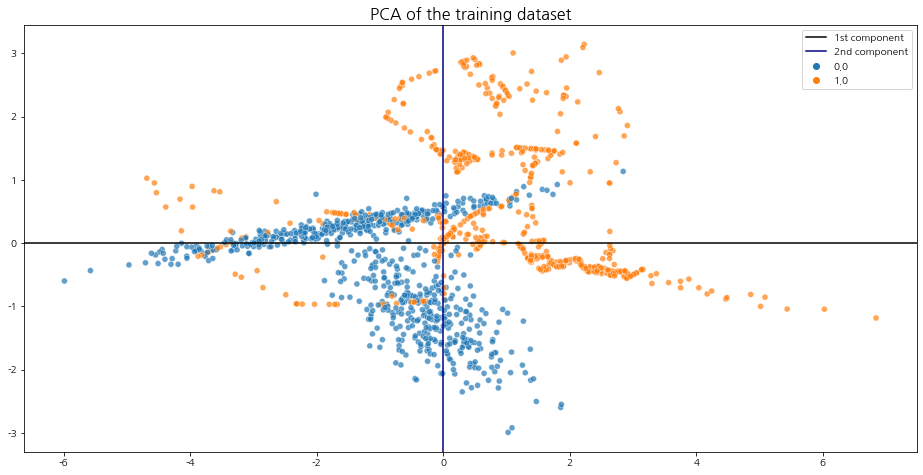

In [149]:
fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)
ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')
sns.scatterplot(x = xpca[:,0], y=xpca[:,1], hue=y_samp,  alpha=.7 )
plt.title('PCA of the training dataset: standard scaled', fontsize = 16)
plt.show()

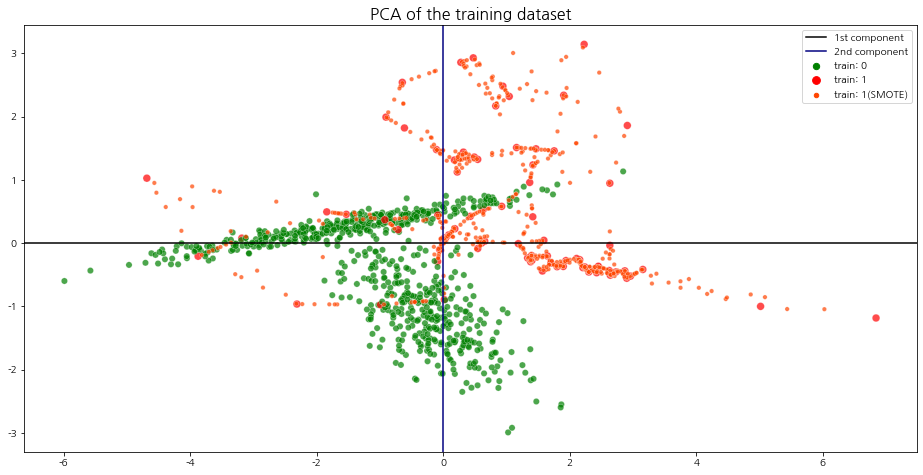

In [159]:
fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)
ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')
sns.scatterplot(x = xpca[:,0], y=xpca[:,1], hue=X_df.values[:, -1], palette={'train: 0':'green', 'train: 1':'red', 'train: 1(SMOTE)':'orangered'}, size=X_df.values[:, -1], 
                sizes={'train: 0':40, 'train: 1':60, 'train: 1(SMOTE)':20}, alpha=.7 )
plt.title('PCA of the training dataset: standard scaled', fontsize = 16)
plt.show()

In [160]:
num_linspace = .02
ll = [np.arange(xpca.min(axis=0)[col] -.2 , xpca.max(axis=0)[col] +.2 ,num_linspace) for col in range(xpca.shape[1]) ]

In [161]:
xx, yy, = np.meshgrid(*ll)

In [162]:
if X_df.shape[1]<=3:
    Z = model_rf.predict_proba(np.c_[xx.ravel(), yy.ravel(),])[:, 1 ]
else:
    Z = model_rf.predict_proba(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel(),]))[:, 1 ]

In [163]:
cm = plt.cm.RdBu_r

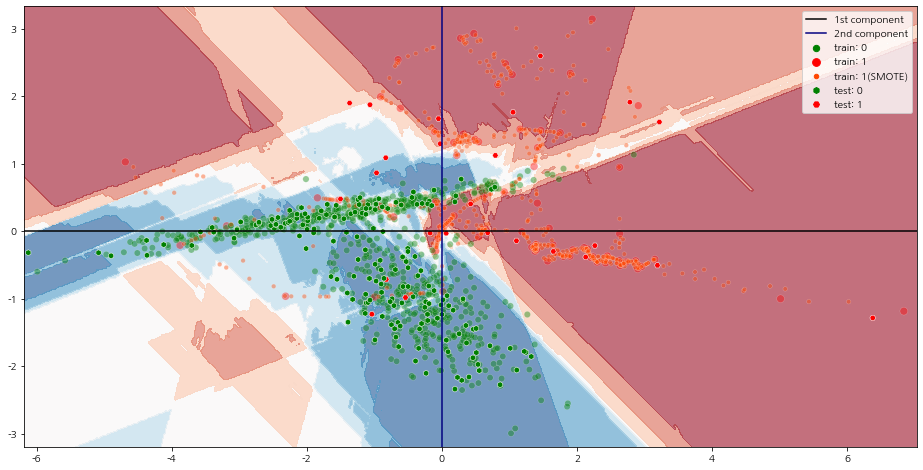

In [168]:
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(1,1, figsize = (16,12))
ax.set_aspect(1)

ax.axline((.0, .0), (pca.transform(pca.components_)[0,0], pca.transform(pca.components_)[0,1]), c='k', label='1st component')
ax.axline((.0, .0), (pca.transform(pca.components_)[1,0], pca.transform(pca.components_)[1,1]), c='navy', label='2nd component')

# Plot filled contours
plt.contourf(xx, yy, Z, cmap=cm, alpha=.6)

# Plot the training points
sns.scatterplot(x = xpca[:,0], y=xpca[:,1], hue=X_df.values[:, -1], palette={'train: 0':'green', 'train: 1':'red', 'train: 1(SMOTE)':'orangered'}, size=X_df.values[:, -1],
                hue_order = ['train: 0', 'train: 1', 'train: 1(SMOTE)'], sizes = {'train: 0':40, 'train: 1':60, 'train: 1(SMOTE)':20}, alpha = .4 )

# Plot the testing points
if data[0].shape[1]<=2:
    sns.scatterplot(x = (X_test)[:, 0], y = (X_test)[:, 1], hue = y_test, palette={0:'green', 1:'red'}, style=y_test, markers={0:'*', 1:'v'}, )
else:
    y_test_str = np.vectorize(lambda x: 'test: 1' if x==1 else 'test: 0')(y_test)
    sns.scatterplot(x = pca.transform(scaler.transform(X_test))[:, 0], y = pca.transform(scaler.transform(X_test))[:, 1], hue = y_test_str, hue_order = ['test: 0', 'test: 1'],
                     palette={'test: 0':'green', 'test: 1':'red'}, style = y_test_str, markers={'test: 0':'h', 'test: 1':'H'},  alpha=1.  )
plt.legend()
plt.show()